In [27]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

In [28]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.portfolio_management.portfolio import Portfolio, OptimizedPortfolio
from financial_common.risk.risk_type import RiskType
import numpy as np

In [29]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [30]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [31]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()

In [32]:
orivault.connect()
a = orivault.retrieve("results")
orivault.disconnect()

In [33]:
valid = a[(a["position_type"]=="long") & (a["selection_type"]!="long_short")].sort_values("pnl",ascending=False)
valid.head(20)

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,rolling_window
16,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,7857.795634,3.489915,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,20
18,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,5218.902775,2.444101,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,20
21,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,3574.180285,3.851456,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,20
376,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,2404.566339,2.319659,1036.603296,1.109109,0.914468,0.524182,1.016495,2.314600,60
378,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,2268.625126,2.172007,1044.483355,1.111008,0.913751,0.517636,1.015859,2.166986,60
561,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,1268.015974,3.011701,421.029872,1.103217,0.915425,0.520727,1.013213,2.999244,100
196,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,1111.866836,1.832719,606.676024,1.108352,0.914346,0.522182,1.015653,1.824074,40
39,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20,1046.602981,3.310698,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,20
201,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20,735.676263,2.557489,287.655706,1.104114,0.914673,0.534727,1.015972,2.539256,40
32,sma_corr,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20,687.545467,2.743947,250.568011,1.097348,0.921367,0.526364,1.013997,2.722889,20


In [34]:
top = valid.head().to_dict("records")[0]
rolling_window = top["rolling_window"]
top

{'ranking_metric': 'sma',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-20 00:00:00'),
 'pnl': 7857.795633874551,
 'coefficient_of_variation': 3.4899148962897732,
 'portfolio_std': 2251.572278231883,
 'average_gain': 1.1098160666634587,
 'average_loss': 0.9153974301174183,
 'win_loss_ratio': 0.5272727272727272,
 'weekly_return': 1.0179090748416941,
 'sharpe_ratio': 3.487585550159361,
 'rolling_window': 20}

In [35]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)	
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [03:43<00:00, 19.12it/s]


In [36]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [37]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [38]:
base_portfolio = Portfolio.from_dict(top)

In [39]:
portfolios = PortfolioSelection.optimize_portfolio(base_portfolio,group_percentages=[0.005,0.01])

In [40]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.28s/it]


In [41]:
a = pd.DataFrame(analysises)
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
0,0,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.005,1851.669285,2.231546,829.769875,1.105758,0.915940,0.502426,1.011309,2.225225,<financial_common.portfolio_management.portfol...
2,2,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.010,410.834275,2.843266,144.493799,1.095905,0.920612,0.509855,1.009986,2.806747,<financial_common.portfolio_management.portfol...
1,1,sma,WEEK,long,STANDARD_DEV,top,risk,coefficient_of_variation,0.005,6.478768,3.164866,2.047091,1.010119,0.992979,0.502426,1.001591,0.602844,<financial_common.portfolio_management.portfol...
3,3,sma,WEEK,long,STANDARD_DEV,top,risk,coefficient_of_variation,0.010,2.547853,4.154474,0.613279,1.004071,0.996796,0.510063,1.000507,-4.449605,<financial_common.portfolio_management.portfol...


In [42]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

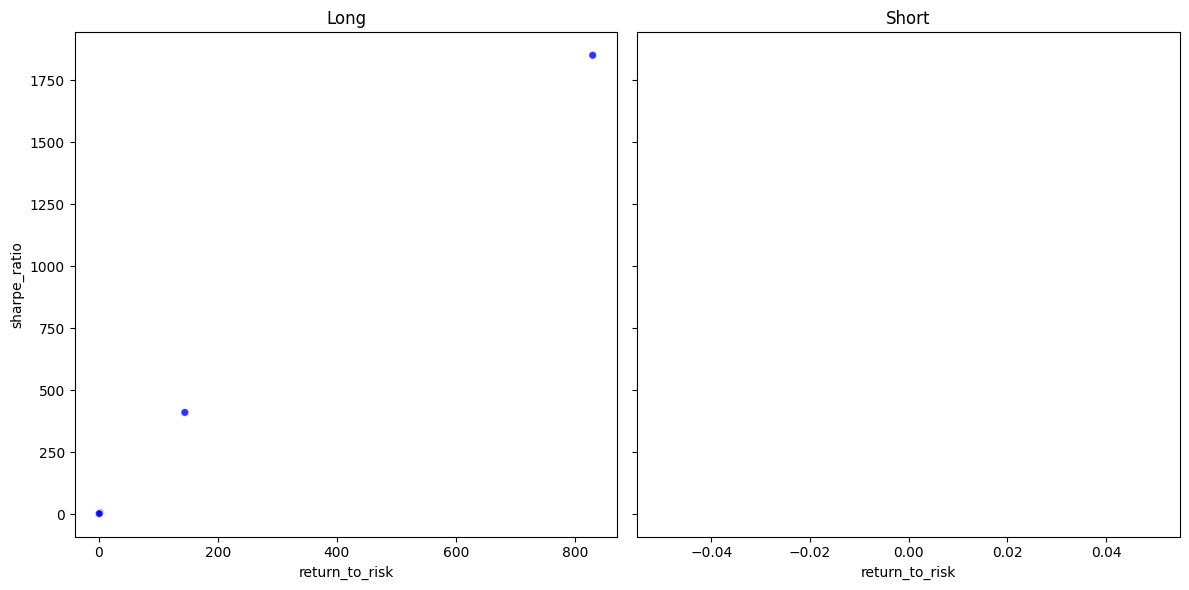

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [44]:
top = a.sort_values("pnl",ascending=False).iloc[0].to_dict()
top["rolling_window"] = rolling_window
top

{'ranking_metric': 'sma',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.005,
 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'),
 'pnl': 1851.6692848823361,
 'coefficient_of_variation': 2.231545565119115,
 'portfolio_std': 829.7698751150072,
 'average_gain': 1.1057579515803295,
 'average_loss': 0.9159400593864574,
 'win_loss_ratio': 0.5024256144890039,
 'weekly_return': 1.011309430512971,
 'sharpe_ratio': 2.225224907632102,
 'portfolio': <financial_common.portfolio_management.portfolio.OptimizedPortfolio at 0x1b0b3fb4390>,
 'color': 'blue',
 'return_to_risk': 2.231545565119115,
 'rolling_window': 20}

In [45]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [46]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [47]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
451,2023-06-01 00:00:00+00:00,1.324675,2313.779106,131.808512,2.924591,2023,6,2,22
299,2020-06-11 00:00:00+00:00,1.324675,366.260287,85.121539,1.888692,2020,6,2,24
257,2019-09-26 00:00:00+00:00,1.324675,83.074876,99.934114,2.217356,2019,9,3,39
288,2020-04-09 00:00:00+00:00,1.269293,185.100253,89.981374,1.996523,2020,4,2,15
337,2021-03-12 00:00:00+00:00,1.263917,796.689931,140.312642,3.113282,2021,3,1,10
286,2020-03-27 00:00:00+00:00,1.253197,139.000773,78.952199,1.751805,2020,3,1,13
264,2019-10-24 00:00:00+00:00,1.224490,98.735787,107.621948,2.387935,2019,10,4,43
59,2016-03-04 00:00:00+00:00,1.191575,4.157340,46.865635,1.039863,2016,3,1,9
390,2022-03-18 00:00:00+00:00,1.181497,1236.317612,128.895795,2.859963,2022,3,1,11
93,2016-10-20 00:00:00+00:00,1.178571,5.372753,54.479381,1.208798,2016,10,4,42


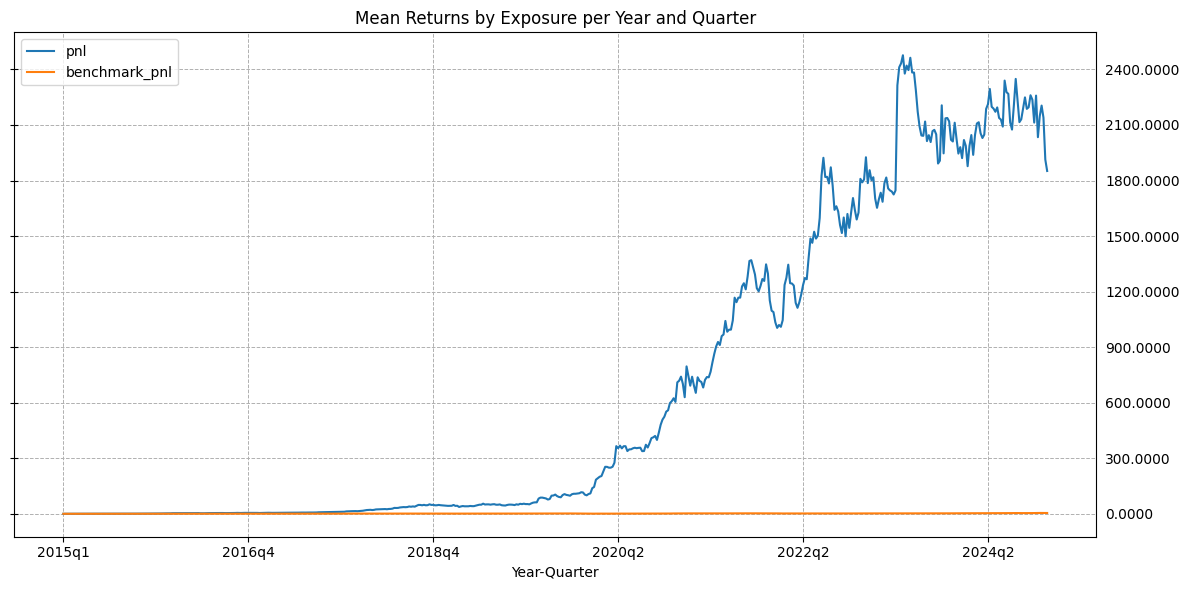

In [48]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [49]:
trades.sort_values(["date","group_percentile"],ascending=False).dropna().head(50).reset_index(drop=True)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,...,selection,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,quarter
0,2024,51,FTFT,2024-12-20 00:00:00+00:00,0.2705,0.3014,0.054107,1.430426,0.135656,1.0,...,True,1.0,1,1.114233,1.114233,1.114233,Future FinTech Group Inc.,4.667678e+06,12,4
1,2024,51,AQB,2024-12-20 00:00:00+00:00,0.5801,0.5240,0.126204,1.585490,0.198043,0.9,...,True,1.0,1,0.903293,0.903293,0.903293,"AquaBounty Technologies, Inc.",2.496899e+06,12,4
2,2024,51,LYEL,2024-12-20 00:00:00+00:00,0.6704,0.6127,0.105643,1.389344,0.188395,0.9,...,True,1.0,1,0.913932,0.913932,0.913932,"Lyell Immunopharma, Inc. Common Stock",1.379226e+08,12,4
3,2024,51,CARM,2024-12-20 00:00:00+00:00,0.4301,0.4179,0.136588,1.922196,0.148741,0.8,...,True,1.0,1,0.971635,0.971635,0.971635,"Carisma Therapeutics, Inc. Common Stock",9.444110e+06,12,4
4,2024,51,ERNA,2024-12-20 00:00:00+00:00,0.2716,0.2501,0.155438,1.573927,0.416674,0.8,...,True,1.0,1,0.920839,0.920839,0.920839,Ernexa Therapeutics Inc. Common Stock,1.343065e+07,12,4
5,2024,51,ONCO,2024-12-20 00:00:00+00:00,0.4200,0.3469,0.261920,1.946007,0.515819,0.7,...,True,1.0,1,0.825952,0.825952,0.825952,"Onconetix, Inc. Common Stock",1.003619e+06,12,4
6,2024,51,DRCT,2024-12-20 00:00:00+00:00,0.6610,0.5500,0.241479,1.671301,0.354618,0.7,...,True,1.0,1,0.832073,0.832073,0.832073,"Direct Digital Holdings, Inc. Class A Common S...",1.274522e+07,12,4
7,2024,51,CLRB,2024-12-20 00:00:00+00:00,0.2577,0.2350,0.477635,5.157538,0.211915,0.6,...,True,1.0,1,0.911913,0.911913,0.911913,Cellectar Biosciences INC NEW,1.428476e+07,12,4
8,2024,51,INO,2024-12-20 00:00:00+00:00,2.1500,1.8400,0.419763,1.729741,0.288528,0.6,...,True,1.0,1,0.855814,0.855814,0.855814,"Inovio Pharmaceuticals, Inc.",7.041305e+07,12,4
9,2024,51,PBM,2024-12-20 00:00:00+00:00,1.8500,3.1800,0.729945,1.618784,0.951031,0.5,...,True,1.0,1,1.324675,1.324675,1.324675,Psyence Biomedical Ltd. Common Shares,2.091533e+06,12,4
